# Interactive Jupyter Notebook to Learn about faster Optimizers and visualize them

## Setup
1. Beginnen Sie damit, den ``import`` Block auszuführen, um zu sehen, ob die benötigten Pakete installiert sind. Installieren Sie fehlende Pakete, bis Sie den Block erfolgreich ausführen können.
2. Gehen Sie durch die Sektionen. Führen Sie die folgenden Schritte für jeden Abschnitt aus
    1. Führen Sie den `Setup`-Block aus. Dadurch werden alle notwendigen Funktionen für den Abschnitt erstellt.
    2. Bearbeite den Block `Task`.
    3. Visualisieren und Testen mit dem `Visualize`-Block

### Import Block

In [1]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from typing import Tuple, List, Callable, Any

### General Setup

In [2]:
# Funktionsdefinitionen
def steep_valley_function():
    # Funktionsterm
    def f(x, y):
        return 0.5 * x**2 + 2 * y**2

    # Gradient der Funktion
    def grad(x, y):
        grad_x = x  # partielle Ableitung nach x
        grad_y = 4 * y  # partielle Ableitung nach y
        return np.array([grad_x, grad_y])

    # Bauen der Funktion
    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def l_shaped_valley_function():
    # Funktionsterm
    def f(x, y):
        return np.where(x > y, (y + 20) ** 2 + x, (x + 20) ** 2 + y)

    # Gradient der Funktion
    def grad(x, y):
        grad_x = np.where(x > y, 1, 2 * (x + 20))  # partielle Ableitung nach x
        grad_y = np.where(x > y, 2 * (y + 20), 1)  # partielle Ableitung nach y
        return np.array([grad_x, grad_y])

    # Bauen der Funktion
    x = np.linspace(-50, 20, 400)
    y = np.linspace(-50, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def asymmetric_convex_function():
    # Funktionsterm
    def f(x, y):
        return (
            0.3 * (x - 10) ** 2
            + 0.2 * (y - 10) ** 2
            + 1.1 * (x + 10) ** 2
            + 1 * (y + 10) ** 2
        )

    # Gradient der Funktion
    def grad(x, y):
        grad_x = 0.6 * (x - 10) + 2.2 * (x + 10)  # partielle Ableitung nach x
        grad_y = 0.4 * (y - 10) + 2 * (y + 10)  # partielle Ableitung nach y
        return np.array([grad_x, grad_y])

    # Bauen der Funktion
    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def symmetric_convex_function():
    # Funktionsterm
    def f(x, y):
        return x**2 + y**2

    # Gradient der Funktion
    def grad(x, y):
        grad_x = 2 * x  # partielle Ableitung nach x
        grad_y = 2 * y  # partielle Ableitung nach y
        return np.array([grad_x, grad_y])

    # Bauen der Funktion
    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


# Learning Rate Scheduling
def power_scheduling(initial_lr, t, s, c=1):
    return initial_lr / (1 + t / s) ** c


def exponential_scheduling(initial_lr, t, s):
    return initial_lr * (0.1 ** (t / s))


def piecewise_constant_scheduling(epoch, boundaries, values):
    for boundary, value in zip(boundaries, values):
        if epoch < boundary:
            return value
    return values[-1]


def performance_scheduling(
    validation_error, prev_validation_error, lr, lambda_factor=0.1
):
    if validation_error > prev_validation_error:
        return lr * lambda_factor
    return lr


def one_cycle_scheduling(t, total_steps, initial_lr, max_lr):
    if t < total_steps / 2:
        return initial_lr + (max_lr - initial_lr) * (2 * t / total_steps)
    return max_lr - (max_lr - initial_lr) * (2 * (t - total_steps / 2) / total_steps)


# Anwenden des Schedulers auf Learning Rate in Schritt t
def apply_lr_scheduler(lr_scheduler, t, lr, scheduler_params):
    if lr_scheduler is None or lr_scheduler == "None":
        return lr
    elif lr_scheduler == "Power":
        return power_scheduling(lr, t, scheduler_params["Power"])
    elif lr_scheduler == "Exponential":
        return exponential_scheduling(lr, t, 2)  # 2 als default fuer s
    elif lr_scheduler == "Piecewise":
        boundaries = list(map(int, scheduler_params["Piecewise Boundaries"].split(",")))
        values = list(map(float, scheduler_params["Piecewise Values"].split(",")))
        return piecewise_constant_scheduling(t, boundaries, values)
    elif lr_scheduler == "Performance":
        prev_validation_error = 0  # Platzhalter, da Loss nicht beruecksichtigt wird
        return performance_scheduling(
            0, prev_validation_error, lr, scheduler_params["Lambda Factor"]
        )
    elif lr_scheduler == "OneCycle":
        total_steps = scheduler_params["Total Steps"]
        max_lr = scheduler_params["Max LR"]
        return one_cycle_scheduling(t, total_steps, lr, max_lr)
    else:
        return lr


# Standardisierte optimize-Funktion
def optimize(
    optimizer_type="Regular",
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    lr_scheduler=None,
    scheduler_params=None,
    print_res=False,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:

    # Fuehre den gewaehlten Optimizer aus
    if optimizer_type == "Regular":
        return regular_gradient_descent(
            function, steps, lr, cur_pos, print_res, lr_scheduler, scheduler_params
        )
    elif optimizer_type == "Momentum":
        return momentum_gradient_descent(
            function,
            steps,
            lr,
            beta1,
            cur_pos,
            print_res,
            lr_scheduler,
            scheduler_params,
        )
    elif optimizer_type == "Nesterov":
        return nesterov_gradient_descent(
            function,
            steps,
            lr,
            beta1,
            cur_pos,
            print_res,
            lr_scheduler,
            scheduler_params,
        )
    elif optimizer_type == "AdaGrad":
        return adagrad_gradient_descent(
            function, steps, lr, cur_pos, print_res, lr_scheduler, scheduler_params
        )
    elif optimizer_type == "RMSProp":
        return rmsprop_gradient_descent(
            function,
            steps,
            lr,
            beta1,
            cur_pos,
            print_res,
            lr_scheduler,
            scheduler_params,
        )
    elif optimizer_type == "Adam":
        return adam_gradient_descent(
            function,
            steps,
            lr,
            beta1,
            beta2,
            cur_pos,
            print_res,
            lr_scheduler,
            scheduler_params,
        )
    elif optimizer_type == "Custom":
        return custom_gradient_descent(
            function,
            steps,
            lr,
            beta1,
            cur_pos,
            print_res,
            lr_scheduler,
            scheduler_params,
        )


# Ausfuehren mehrerer Optimizer
def optimize_multiple(
    optimizers=["Regular", "momentum"],
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    results = []
    for optimizer in optimizers:
        results.append(
            optimize(optimizer, function, steps, lr, beta1, beta2, cur_pos, print_res)
        )
    return results


# Plotting Funktion, die eine Liste von Ergebnissen nimmt und ein Plot zurueckgibt (noch nicht interaktiv)
def plot_optimization_path(optimizer_results):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")  # 3D-Visualisierung
    ax2 = fig.add_subplot(1, 2, 2)  # 2D Heatmap

    # Funktion aus ersten Optimizer herleiten
    f = optimizer_results[0][0]
    x_range = np.linspace(-20, 20, 1000)
    y_range = np.linspace(-20, 20, 1000)
    X, Y = np.meshgrid(x_range, y_range)
    Z = f(X, Y)

    # Ermitteln des Minimums
    min_z = np.min(Z)
    min_pos = np.where(Z == min_z)
    min_x = X[min_pos][0]
    min_y = Y[min_pos][0]

    # Plot 3D Visualisierung
    ax1.plot_surface(X, Y, Z, alpha=0.5, cmap="viridis", edgecolor="none")
    ax1.set_title("3D View - Optimization Paths")

    # Markiere Minimum in 3D
    ax1.scatter(
        min_x, min_y, min_z, marker="8", color="black", s=30, alpha=0.5, label="Minumum"
    )
    # ax1.text(min_x, min_y, min_z, f'({min_x:.2f}, {min_y:.2f}, {min_z:.2f})', color='red')

    # Plot 2D heatmap
    ax2.contourf(X, Y, Z, levels=100, cmap="viridis")
    ax2.set_title("Top-Down View (2D) - Optimization Paths")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")

    ax2.scatter(
        min_x,
        min_y,
        marker="8",
        color="black",
        linewidths=5,
        alpha=0.5,
        label="Minumum",
    )

    # Farbschema fuer Optimizer
    color_map = {
        "Regular": "red",
        "Momentum": "blue",
        "Nesterov": "green",
        "AdaGrad": "orange",
        "RMSProp": "purple",
        "Adam": "black",
    }

    # Plotten des Pfades anhand der positions-Liste
    for idx, (f, positions, z_values, name) in enumerate(optimizer_results):
        positions_array = np.array(positions)
        color = color_map.get(name, "gray")  # Default to gray if name not found

        # 3D Pfad
        ax1.scatter(
            positions_array[:, 0],
            positions_array[:, 1],
            z_values,
            color=color,
            s=50,
            label=name,
        )

        # 2D Pfad
        ax2.plot(
            positions_array[:, 0],
            positions_array[:, 1],
            marker="o",
            color=color,
            markersize=5,
            linestyle="--",
            linewidth=2,
            label=name,
        )

    # Bereich eingrenzen, um innerhalb von Definitionsbereich zu bleiben
    ax1.set_xlim(-20, 20)
    ax1.set_ylim(-20, 20)

    ax2.set_xlim(-20, 20)
    ax2.set_ylim(-20, 20)

    # Legende
    ax1.legend()
    ax2.legend()

    plt.show()

In [3]:
# Funktion, welche Plots um interaktive Elemente ergaenzt
def visualize_optimizer(
    optimizer_multiselect_options=[
        "Regular",
        "Momentum",
        "Nesterov",
        "AdaGrad",
        "RMSProp",
        "Adam",
    ]
):
    # Optimizer Konfiguration
    optimizer_settings = {
        "Regular": {
            "lr": widgets.FloatSlider(
                value=0.1, min=0, max=2, step=0.01, description="Learning Rate"
            )
        },
        "Momentum": {
            "lr": widgets.FloatSlider(
                value=0.1, min=0, max=2, step=0.01, description="Learning Rate"
            ),
            "beta1": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"
            ),
        },
        "Nesterov": {
            "lr": widgets.FloatSlider(
                value=0.1, min=0, max=2, step=0.01, description="Learning Rate"
            ),
            "beta1": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"
            ),
        },
        "AdaGrad": {
            "lr": widgets.FloatSlider(
                value="2", min=0, max=2, step=0.01, description="Learning Rate"
            )
        },
        "RMSProp": {
            "lr": widgets.FloatSlider(
                value="2", min=0, max=2, step=0.01, description="Learning Rate"
            ),
            "beta1": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"
            ),
        },
        "Adam": {
            "lr": widgets.FloatSlider(
                value="2", min=0, max=2, step=0.01, description="Learning Rate"
            ),
            "beta1": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"
            ),
            "beta2": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.001, description="Beta2 Factor"
            ),
        },
        "Custom": {
            "lr": widgets.FloatSlider(
                value="2", min=0, max=2, step=0.01, description="Learning Rate"
            ),
            "beta1": widgets.FloatSlider(
                value=0.9, min=0, max=1, step=0.01, description="Beta1 Factor"
            ),
        },
    }

    # Nur ausgewaehlte Optimizer zur Konfiguration freigeben
    optimizer_settings = {
        key: value
        for key, value in optimizer_settings.items()
        if key in optimizer_multiselect_options
    }

    # Funktions-Auswahl
    func_dropdown = widgets.Dropdown(
        description="Function",
        options=[
            ("Steep Valley Function", steep_valley_function),
            ("Symmetric Convex Function", symmetric_convex_function),
            ("Asymmetric Convex Function", asymmetric_convex_function),
            ("L-shaped Valley Function", l_shaped_valley_function),
        ],
        layout=widgets.Layout(width="100%"),
    )
    x_slider = widgets.IntSlider(
        value=15,
        min=-20,
        max=20,
        step=1,
        description="Starting X",
        layout=widgets.Layout(width="100%"),
    )
    y_slider = widgets.IntSlider(
        value=10,
        min=-20,
        max=20,
        step=1,
        description="Starting Y",
        layout=widgets.Layout(width="100%"),
    )
    steps_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description="Steps",
        layout=widgets.Layout(width="100%"),
    )

    # Optimizer-Auswahl
    optimizer_multiselect = widgets.SelectMultiple(
        description="Optimizers",
        options=list(optimizer_settings.keys()),
        value=[list(optimizer_settings.keys())[0]],
        layout=widgets.Layout(width="100%"),
    )

    # Toggle fuer Konfiguration einzelnder Optimizer
    optimizer_toggle = widgets.ToggleButtons(
        description="Configure Optimizer",
        options=list(optimizer_settings.keys()),
        value=list(optimizer_settings.keys())[0],
        layout=widgets.Layout(width="100%"),
    )

    # UI-Platzhalter fuer Konfiguration
    optimizer_settings_box = widgets.VBox()

    # Optimizer Konfiguration entsprechend Auswahl in UI einbinden
    def update_optimizer_settings(change):
        selected_optimizer = change["new"]
        boxes = [widgets.Label(value=selected_optimizer)]
        for setting, widget in optimizer_settings[selected_optimizer].items():
            boxes.append(widget)
        optimizer_settings_box.children = boxes

    optimizer_toggle.observe(update_optimizer_settings, names="value")

    # Standard-Auswahl bei Initialisierung
    update_optimizer_settings({"new": optimizer_toggle.value})

    # Learning Rate Scheduler Auswahl
    lr_schedulers = [
        "None",
        "Power",
        "Exponential",
        "Piecewise",
        "Performance",
        "OneCycle",
    ]
    lr_scheduler_dropdown = widgets.Dropdown(
        description="LR Scheduler",
        options=lr_schedulers,
        value="None",
        layout=widgets.Layout(width="100%"),
    )

    # Aktualisieren der Plots
    def update_plot(
        optimizers, function, steps, initialX, initialY, lr_scheduler, **kwargs
    ):
        cur_pos = np.array([initialX, initialY])
        results = []
        for optimizer in optimizers:
            params = {
                key: kwargs.get(f"{optimizer}_{key}")
                for key in optimizer_settings[optimizer].keys()
            }
            scheduler_params = {
                "Power": 2,
                "Piecewise Boundaries": "10,20",
                "Piecewise Values": "0.1,0.01,0.001",
                "Lambda Factor": 0.1,
                "Total Steps": 12,
                "Max LR": 0.2,
            }
            results.append(
                optimize(
                    optimizer,
                    function,
                    steps,
                    cur_pos=cur_pos,
                    lr_scheduler=lr_scheduler,
                    scheduler_params=scheduler_params,
                    **params,
                )
            )
        plot_optimization_path(results)

    # Verknuepfen von UI zu Plots
    out = widgets.interactive_output(
        update_plot,
        {
            "optimizers": optimizer_multiselect,
            "function": func_dropdown,
            "steps": steps_slider,
            "initialX": x_slider,
            "initialY": y_slider,
            "lr_scheduler": lr_scheduler_dropdown,
            **{
                f"{opt}_{param}": widget
                for opt, settings in optimizer_settings.items()
                for param, widget in settings.items()
            },
        },
    )

    # UI-Elemente
    ui = widgets.VBox(
        [
            widgets.HBox([x_slider, y_slider]),
            widgets.HBox([steps_slider, func_dropdown]),
            optimizer_multiselect,
            optimizer_toggle,
            optimizer_settings_box,
            lr_scheduler_dropdown,
        ]
    )

    display(ui, out)

## Abschnitt 1: Regular vs Momentum Optimizer

## Setup
Hier werden die Functions für den Step und Gradient Descent der zwei ersten Optimizer gesetzt.

In [4]:
# --------------------------------------------------------------
# Regular Gradient Descent Step


def regular_gradient_step(pos, lr, grad):
    return pos - lr * grad(*pos)


def regular_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:
    X, Y, Z, f, grad = function()
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        cur_pos = regular_gradient_step(cur_pos, lr, grad)
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Regular")


# --------------------------------------------------------------
# Momentum Gradient Descent Step


def momentum_step(pos, lr, beta, momentum, grad):
    gradient = grad(*pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def momentum_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        momentum, cur_pos = momentum_step(cur_pos, lr, beta1, momentum, grad)
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Momentum")

## Aufgabe / Visualisieren
Die Aufgabe in Abschnitt 1 besteht darin, mit den Optimierern Regular und Momentum herumzuspielen und sich mit dem Visualisierungstool vertraut zu machen.

Versuchen Sie, diese Fragen (für sich selbst) zu beantworten:
- Wie verhalten sich die Optimierer bei unterschiedlichen ``Starting X``- und ``Starting Y``-Werten?
- Wie verändert sich das Verhalten des Optimierers, wenn die ``Learning Rate`` angepasst wird?
- Welcher Teil des Verhaltens des Optimierers wird durch den ``Beta1-Faktor`` beeinflusst?
- Wie verhält sich der Optimierer bei verschiedenen ``Function(s)``?

Tipps:
- Sie können mehrere Optimierer auf einmal auswählen, indem Sie die Umschalttaste während der Auswahl gedrückt halten.

In [5]:
visualize_optimizer(optimizer_multiselect_options=["Regular", "Momentum"])

Output()

## Abschnitt 2: Nesterov Accelerated Gradient (NAG)

### (Setup)
Diese Section bedarf keines weiteren Setup

### Aufgabe
Ihre Aufgabe ist es, die Schrittfunktion für den Nesterov Accelerated Gradient Descent (kurz: NAG) zu definieren.

Tipps:
- Schauen Sie sich die mathematische Definition genau an
- Orientieren Sie sich an der Schrittfunktion des Momentum-Optimierers

Nesterov Equation:
$$ m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m) $$
$$ \theta \leftarrow \theta + m $$

In [6]:
def nesterov_step(pos, lr, beta, momentum, grad):
    momentum = beta * momentum - lr * grad(*pos + beta * momentum)
    pos = pos + momentum
    return pos, momentum


def nesterov_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)  # Momentum bei Initialisiern
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        cur_pos, momentum = nesterov_step(cur_pos, lr, beta1, momentum, grad)
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos.copy())  # Speichere neue Position
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Nesterov")

### Visualize

In [8]:
visualize_optimizer(optimizer_multiselect_options=["Nesterov", "Momentum"])

Output()

## Abschnitt 3: AdaGrad, RMSProp und Adam

### Aufgabe
Ihre Aufgabe ist es, den Verlauf der Variable s sowohl für Adagrad als auch für RMSProp zu erklären.
Denken Sie an die folgenden Fragen:
- Welcher Unterschied ist bei der Entwicklung von s zwischen den Optimizern erkennbar? 
- Warum ist das der Fall?
- Welche Rolle spielt s in beiden Optimierern?

### Formeln:
AdaGrad
$$ s \leftarrow s + \nabla_{\theta} J(\theta)^2 $$
$$ \theta \leftarrow \theta - \frac{\eta}{\sqrt{s + \epsilon}} \cdot \nabla_{\theta} J(\theta)  $$

RMSProp 
$$ \mathbf{s} \leftarrow \beta \mathbf{s} + (1-\beta) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{\mathbf{s} + \epsilon} $$


In [13]:
adagrad_s = []
rmsprop_s = []


def adagrad_step(pos, lr, grad, s):
    epsilon = 10 ** (-10)  # Abaendern, falls benoetigt
    gradient = grad(*pos)
    s += gradient**2  # akkumulierten quadrierten Gradienten
    adjusted_lr = lr / (np.sqrt(s) + epsilon)
    pos = pos - adjusted_lr * gradient
    return pos, s


def adagrad_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]
    global adagrad_s
    s = np.zeros(2)  # Initiale Summe der Gradienten
    adagrad_s = []
    for i in range(steps):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        cur_pos, s = adagrad_step(cur_pos, lr, grad, s)
        adagrad_s.append(s.copy())
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos.copy())  # Speichere aktuelle Position
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "AdaGrad")


def rmsprop_step(pos, lr, grad, s, beta=0.9, epsilon=1e-8):
    gradient = grad(*pos)
    s = beta * s + (1 - beta) * gradient**2
    pos = pos - (lr * gradient / (np.sqrt(s + epsilon)))
    return pos, s


def rmsprop_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]
    global rmsprop_s
    s = np.zeros_like(cur_pos)
    rmsprop_s = []
    for i in range(steps):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        cur_pos, s = rmsprop_step(cur_pos, lr, grad, s, beta1)  # RMS Step
        rmsprop_s.append(s.copy())
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos.copy())  # Speichere aktuelle Position
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "RMSProp")


def adam_step(pos, lr, grad, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    gradient = grad(*pos)
    m = (
        beta1 * m + (1 - beta1) * gradient
    )  # Aktualisierung der verzerrten Schaetzung des ersten Moments
    v = (
        beta2 * v + (1 - beta2) * gradient**2
    )  # Aktualisierung der verzerrten Schaetzung des zweiten Moments
    m_hat = m / (
        1 - beta1**t
    )  # Berechnung der verzerrungskorrigierten Schaetzung des ersten Moments
    v_hat = v / (
        1 - beta2**t
    )  # Berechnung der verzerrungskorrigierten Schaetzung des zweiten Moments
    pos = pos - lr * m_hat / (np.sqrt(v_hat) + epsilon)  # Aktualisiere Parameter
    return pos, m, v


def adam_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.99,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]

    m = np.zeros_like(cur_pos)  # Initialisierung Vektor ersten Moments
    v = np.zeros_like(cur_pos)  # Initialisierung Vektor zweiten Moments
    t = 0  # Initialisierung timestep

    positions = [cur_pos.copy()]  # Speichere Start-Position

    for i in range(1, steps + 1):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        t += 1  # Erhoehen timestep
        cur_pos, m, v = adam_step(cur_pos, lr, grad, m, v, t, beta1, beta2)  # Adam Step
        cur_pos = np.clip(cur_pos, -20, 20)  # Um Punkte außerhalb von Plot zu vermeiden
        positions.append(cur_pos.copy())  # Speichere aktuelle Position
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "Adam")

def plot_s_values(adagrad_s, rmsprop_s):
    if not np.array(adagrad_s).any() or not np.array(rmsprop_s).any():
        raise SystemExit("Verwende erste beide Optimizer in der Visualisierung")

    # Konvertierte Listen
    adagrad_s = np.array(adagrad_s)
    rmsprop_s = np.array(rmsprop_s)

    plt.figure(figsize=(14, 8))

    # Plot fuer jede Dimenstion
    plt.plot(adagrad_s[:, 0], label="AdaGrad - X", marker="o", color="orange")
    plt.plot(
        adagrad_s[:, 1],
        label="AdaGrad - Y",
        marker="o",
        linestyle="dashed",
        color="orange",
    )
    plt.plot(rmsprop_s[:, 0], label="RMSProp - X", marker="x", color="purple")
    plt.plot(
        rmsprop_s[:, 1],
        label="RMSProp - Y",
        marker="x",
        linestyle="dashed",
        color="purple",
    )

    plt.title("Evolution of s over Steps for AdaGrad and RMSProp")
    plt.xlabel("Steps")
    plt.ylabel("s")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
visualize_optimizer(optimizer_multiselect_options=["AdaGrad", "RMSProp"])

Output()

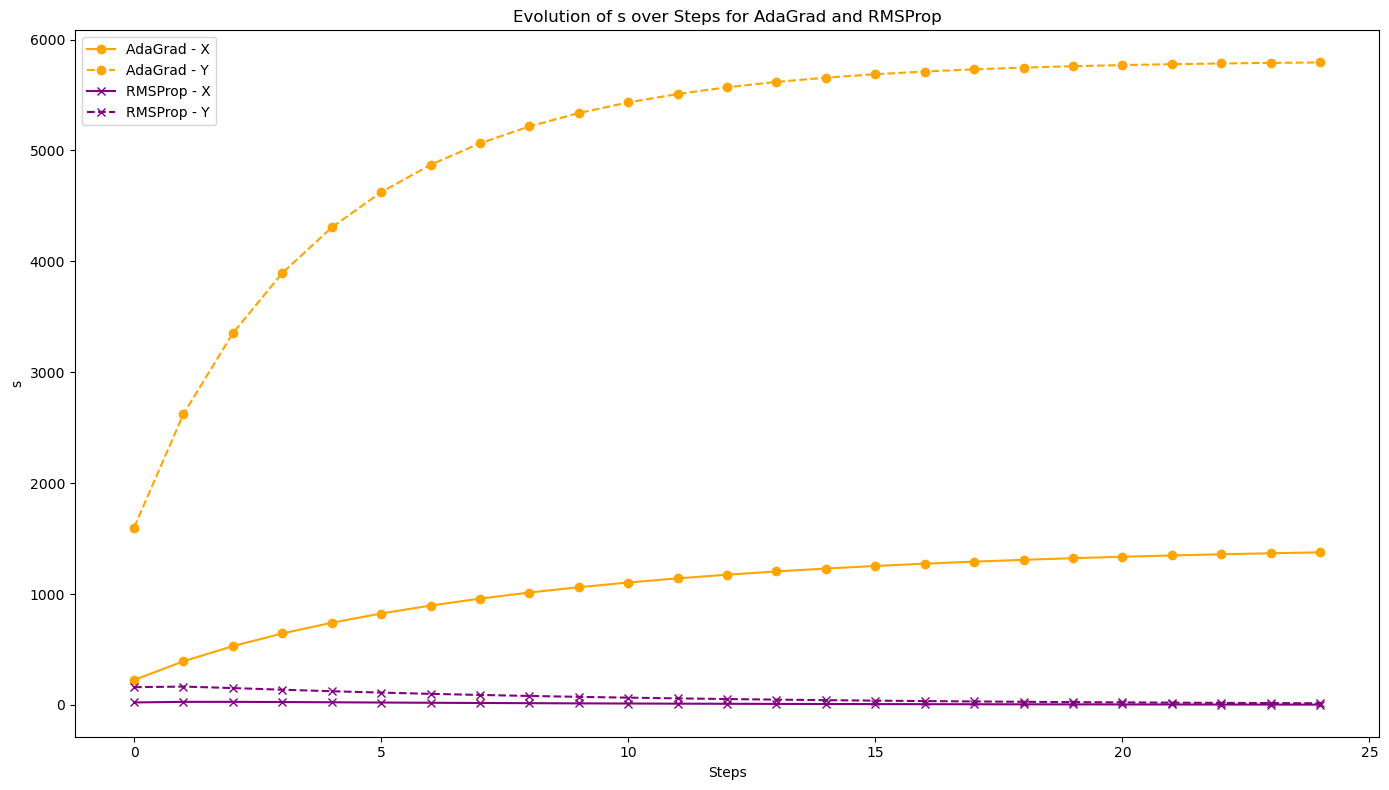

In [16]:
plot_s_values(adagrad_s, rmsprop_s)

## Section X: Eigener Optimizer
In dieser Section sollen Sie ihren eigenen Optimizer implementieren mit dem Haken, dass Zufall eingebunden werden muss

Ziel ist es als schnellste(r) Richtung Optimum zu gelangen

In [12]:
def custom_step(pos, lr, grad):
    pos = pos - lr * grad(*pos)
    # TODO Implementiere eigene Logik
    # Zufall kann durch randint(a,b) eingebunden werden
    return pos


def custom_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
    lr_scheduler=None,
    scheduler_params=None,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]

    positions = [cur_pos.copy()]  # Speichern der Start-Positionen

    for i in range(1, steps + 1):
        lr = apply_lr_scheduler(lr_scheduler, i, lr, scheduler_params)
        cur_pos = custom_step(cur_pos, lr, grad)  # Custom Step
        cur_pos = np.clip(
            cur_pos, -20, 20
        )  # Um Punkte außerhalb des Plots zu vermeiden
        positions.append(cur_pos.copy())  # Speichere aktuelle Position
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "Custom")


visualize_optimizer(["Custom"])

Output()